**Algorithm**: Time Step Iteration on the Network

**Input**: Graph `g`, Time steps `times`, Model parameters `beta1`, `beta2`, `beta3`, `alpha1`, `alpha2`, `mu`, `delta_I`, `delta_T`, `Lambda`

**Output**: Updated graph `g`, Status counts `S_count`, `E_count`, `I_count`, `Tt_count`, `R_count`, `N_count`, Network metrics `degree_dist`, `clustering_coeff`, `avg_path_length`, `largest_comp_size`

1. **For each time step t in the simulation:**
   1. Save the current status of each node.
   2. **For each type of removal (Infection, Treatment, natural death):**
      1. Calculate the number of nodes to remove `nodes_to_remove_count`
      2. Separate `nodes_to_remove_count` into a floor value `floor_value` and a fractional part `fractional_part`
      3. **if** `floor_value` > 0 **then**
         1. Remove `floor_value` number of nodes
      4. **if** `fractional_part` > 0 **then**
         1. Remove an additional node with a probability equal to `fractional_part`
   3. Calculate the number of nodes to add `nodes_to_add_count`
   4. Separate `nodes_to_add_count` into a floor value `floor_value` and a fractional part `fractional_part`
   5. **if** `floor_value` > 0 **then**
      1. Add `floor_value` number of nodes
   6. **if** `fractional_part` > 0 **then**
      1. Add an additional node with a probability equal to `fractional_part`
   7. **for** each node in the graph **do**
      1. Get the current status of the node.
      2. Generate a random number `rand`
      3. If the node is Susceptible and `rand` < `beta1` * `I` / `N`, change the status to Exposed
      4. If the node is Exposed and `rand` < `beta2`, change the status to Infected
      5. If the node is Infected:
         1. Generate another random number `rand2`
         2. If `rand` < `beta3`, change the status to Recovered
         3. If `rand2` < `alpha1`, change the status to Treatment
      6. If the node is under Treatment and `rand` < `alpha2`, change the status to Recovered
   8. Count the number of nodes in each status and store these counts in `S_count`, `E_count`, `I_count`, `Tt_count`, `R_count`, `N_count`
   9. Calculate various network metrics and store these metrics in `degree_dist`, `clustering_coeff`, `avg_path_length`, `largest_comp_size`
   10. If the current time step is a multiple of 10, plot the network


In [11]:
# Load the necessary libraries
library(igraph)  # For network analysis and visualization
library(deSolve)  # For solving differential equations
library(foreach) # For parallel processing
library(doParallel) # For parallel processing
library(ggplot2) # For plotting
library(dplyr) # For data manipulation

Warning message:
"package 'ggplot2' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:igraph':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




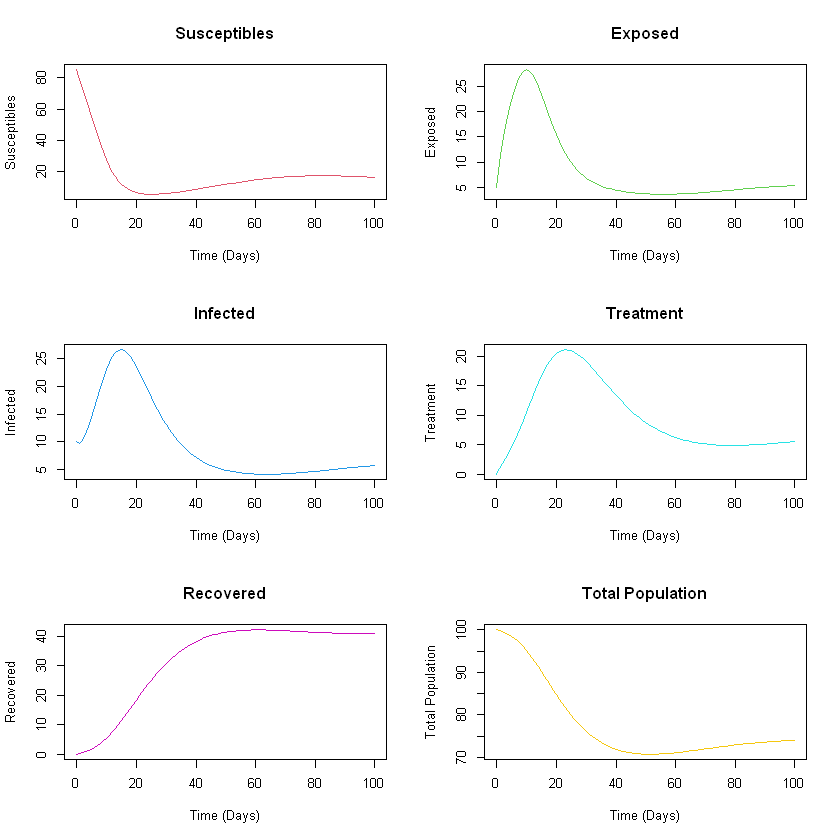

In [7]:
# Define the model parameters
Lambda <- 1.1  # Lambda represents the number of births in the population
beta1 <- 0.8  # Beta1 is the rate of transfer from Susceptible (S) to Exposed (E)
beta2 <- 0.18  # Beta2 is the rate of transfer from Exposed (E) to Infected (I)
beta3 <- 0.02  # Beta3 is the rate of transfer from Infected (I) to Recovered (R)
alpha1 <- 0.1  # Alpha1 is the rate of transfer from Infected (I) to Treatment (Tt)
alpha2 <- 0.055  # Alpha2 is the rate of transfer from Treatment (Tt) to Recovered (R)
delta_I <- 0.03  # Delta_I is the rate of death due to Infection
delta_T <- 0.03  # Delta_T is the rate of death during Treatment
mu <- 0.01  # Mu is the rate of natural death

# Calculate the reproduction number (R0)
# R0 is a key parameter in epidemiology, representing the average number of secondary infections produced by a typical case of an infection in a population where everyone is susceptible.
R0 <- (beta1 * beta2) / ((beta3 + mu + delta_I + alpha1) * (beta2 + mu) * (mu + delta_T + alpha2))

# Define the initial conditions
n <- 100  # Total population
S <- 85  # Number of susceptible individuals
I <- 10  # Number of infected individuals
E <- 5  # Number of exposed individuals
R <- 0  # Number of recovered individuals
Tt <- 0  # Number of individuals under treatment
N <- S + E + I + R + Tt  # Total population (should be equal to n)

# Define the SEITR model
# This function represents the system of differential equations for the SEITR model.
SEITR <- function(t, state, parameters) {
  with(as.list(c(state, parameters)), {
    dS <- Lambda - (beta1 * S * I) / N - mu * S
    dE <- (beta1 * S * I) / N - (beta2 + mu) * E
    dI <- beta2 * E - (beta3 + mu + delta_I + alpha1) * I
    dT <- alpha1 * I - (mu + delta_T + alpha2) * Tt
    dR <- beta3 * I + alpha2 * Tt - mu * R
    dN <- Lambda - N * mu - delta_I * I - delta_T * Tt
    list(c(dS, dE, dI, dT, dR, dN))
  })
}

# Define the initial state
state <- c(S = S, E = E, I = I, Tt = Tt, R = R, N = n)

# Define the parameters
parameters <- c(Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2, delta_I = delta_I, delta_T = delta_T, mu = mu)

# Define the time steps
times <- seq(0, 100, by = 1)

# Solve the system of ODEs using the 'ode' function from the 'deSolve' package
out <- ode(y = state, times = times, func = SEITR, parms = parameters)

# Plot each status separately
# This section of the code creates six separate plots for each status (S, E, I, Tt, R, N) over time.
par(mfrow = c(3, 2))  # Set up a 3x2 grid for the plots
# Each plot shows the number of individuals in a particular status at each time step.
plot(out[, "time"], out[, "S"], type = "l", col = 2, xlab = "Time (Days)", ylab = "Susceptibles", main = "Susceptibles")
plot(out[, "time"], out[, "E"], type = "l", col = 3, xlab = "Time (Days)", ylab = "Exposed", main = "Exposed")
plot(out[, "time"], out[, "I"], type = "l", col = 4, xlab = "Time (Days)", ylab = "Infected", main = "Infected")
plot(out[, "time"], out[, "Tt"], type = "l", col = 5, xlab = "Time (Days)", ylab = "Treatment", main = "Treatment")
plot(out[, "time"], out[, "R"], type = "l", col = 6, xlab = "Time (Days)", ylab = "Recovered", main = "Recovered")
plot(out[, "time"], out[, "N"], type = "l", col = 7, xlab = "Time (Days)", ylab = "Total Population", main = "Total Population")

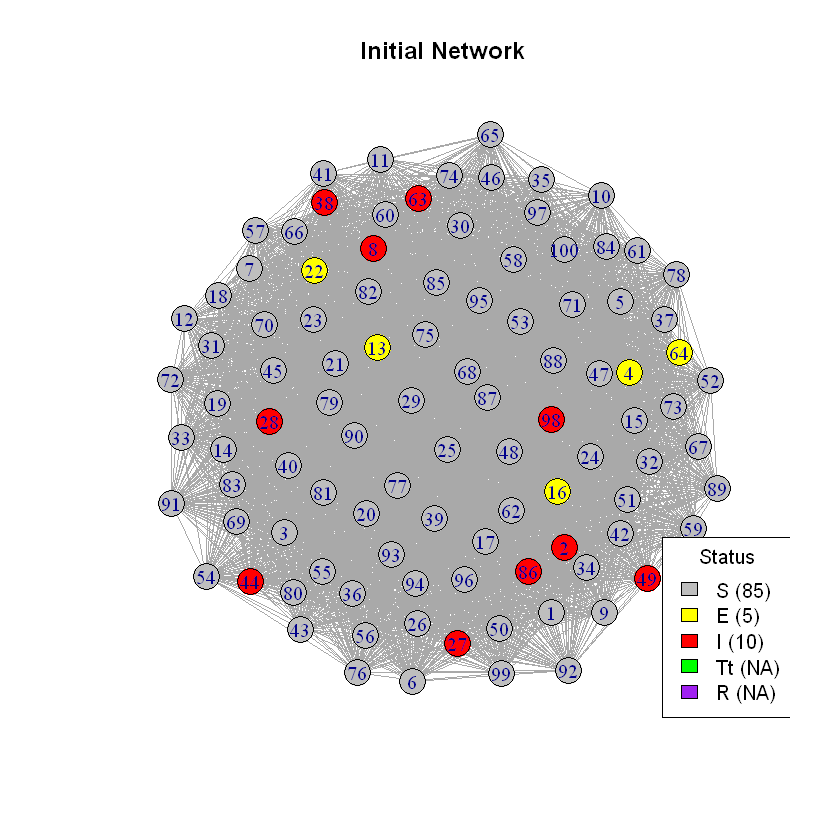

In [8]:
# Create the graph
# This section of the code creates an initial network (graph) using the Erdos-Renyi model.
init_p <- 0.9  # The probability of creating an edge between any two nodes
g <- erdos.renyi.game(n, p = init_p)  # Create the graph
# Assign labels and statuses to the nodes
V(g)$label <- 1:n  # Label the nodes with numbers from 1 to n
V(g)$status <- "S"  # Initially, all nodes are Susceptible (S)
# Randomly assign the other statuses (E, I, Tt, R) to the nodes
V(g)$status[sample(1:n, size = I)] <- "I"
V(g)$status[sample(setdiff(1:n, which(V(g)$status == "I")), size = E)] <- "E"
V(g)$status[sample(setdiff(1:n, which(V(g)$status %in% c("I", "E"))), size = Tt)] <- "Tt"
V(g)$status[sample(setdiff(1:n, which(V(g)$status %in% c("I", "E", "Tt"))), size = R)] <- "R"

# Initialize counters for each status
S_count <- S
E_count <- E
I_count <- I
Tt_count <- Tt
R_count <- R
N_count <- N

# Initialize vectors to store metrics
# These vectors will store various network metrics at each time step.
degree_dist <- vector("list", length(times))  # Degree distribution
clustering_coeff <- numeric(length(times))  # Clustering coefficient
avg_path_length <- numeric(length(times))  # Average path length
largest_comp_size <- numeric(length(times))  # Size of the largest connected component

# Define a color mapping for the statuses
status_colors <- c("S" = "gray", "E" = "yellow", "I" = "red", "Tt" = "green", "R" = "purple")

# Plot the initial network
# The nodes are colored according to their status.
par(mfrow = c(1, 1))  # Set up a 1x1 grid for the plot
plot(g, vertex.color = status_colors[V(g)$status], vertex.label = V(g)$label, vertex.size=10)
title(paste("Initial Network"))
# Create a legend showing the number of nodes in each status
status_counts <- table(V(g)$status)
status_labels <- paste(names(status_colors), " (", status_counts[names(status_colors)], ")", sep = "")
legend("bottomright", legend = status_labels, fill = status_colors, title = "Status")

Time 0 : Node 8 with status I removed due to Infection
Time 0 : Node 49 with status I removed
Time 0 : New node 101 added with status S 
Time 0 : Node 4 changed status from E to I
Time 0 : Node 37 changed status from S to E
Time 0 : Node 43 changed status from S to E
Time 0 : Node 47 changed status from S to E
Time 0 : Node 57 changed status from S to E
Time 0 : Node 60 changed status from S to E
Time 0 : Node 62 changed status from S to E
Time 0 : Node 63 changed status from I to Tt
Time 0 : Node 70 changed status from S to E
Time 0 : Node 79 changed status from S to E
Time 0 : Node 97 changed status from S to E
Time 1 : Node 23 with status S removed
Time 1 : New node 102 added with status S 
Time 1 : Node 10 changed status from S to E
Time 1 : Node 16 changed status from E to I
Time 1 : Node 20 changed status from S to E
Time 1 : Node 35 changed status from S to E
Time 1 : Node 37 changed status from E to I
Time 1 : Node 46 changed status from S to E
Time 1 : Node 59 changed status f

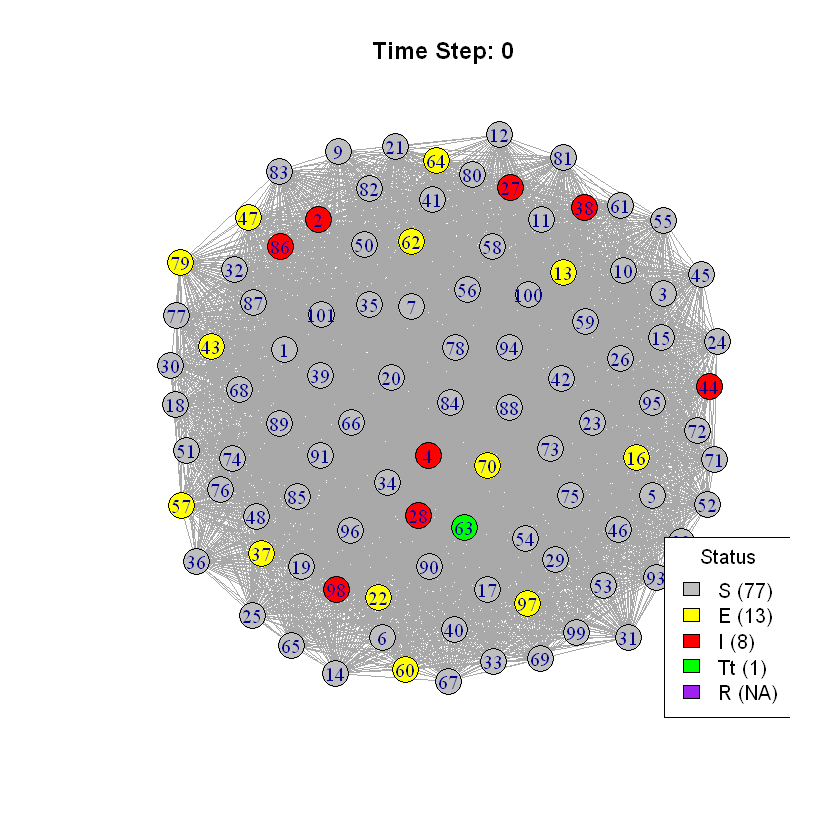

Time 11 : Node 100 with status Tt removed during Treatment
Time 11 : Node 9 with status E removed
Time 11 : New node 114 added with status S 
Time 11 : Node 6 changed status from S to E
Time 11 : Node 46 changed status from Tt to R
Time 11 : Node 52 changed status from Tt to R
Time 11 : Node 65 changed status from I to Tt
Time 11 : Node 72 changed status from E to I
Time 11 : Node 74 changed status from S to E
Time 11 : Node 77 changed status from I to Tt
Time 11 : Node 92 changed status from E to I
Time 11 : Node 95 changed status from E to I
Time 11 : Node 101 changed status from E to I
Time 11 : Node 110 changed status from S to E
Time 11 : Node 113 changed status from S to E
Time 12 : Node 20 with status I removed due to Infection
Time 12 : Node 47 with status I removed
Time 12 : New node 115 added with status S 
Time 12 : New node 116 added with status S 
Time 12 : Node 26 changed status from E to I
Time 12 : Node 36 changed status from E to I
Time 12 : Node 42 changed status from

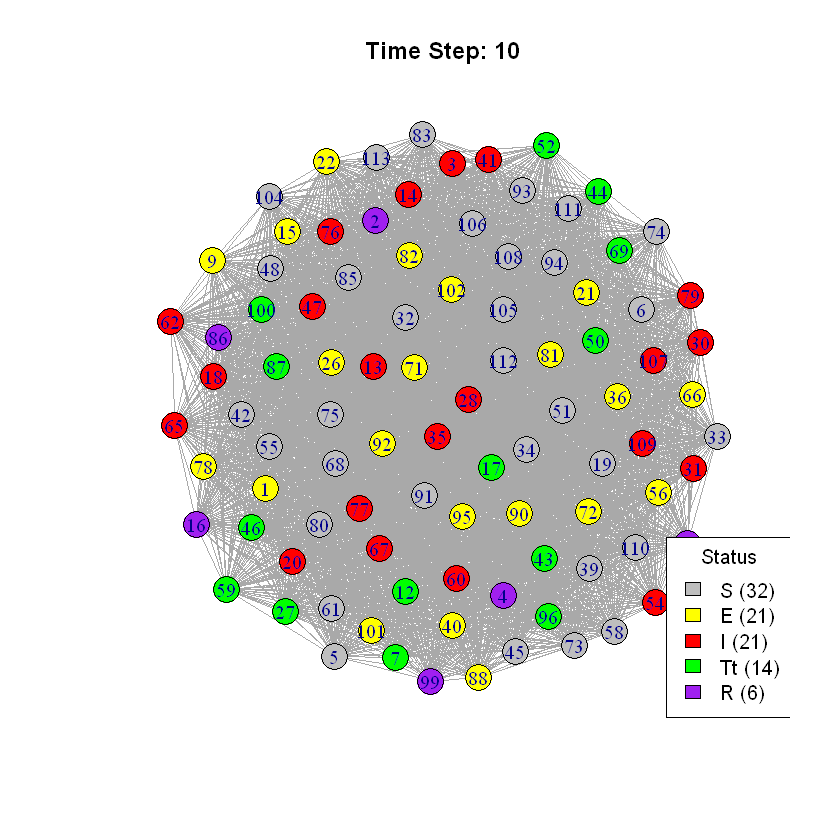

Time 21 : Node 82 with status Tt removed during Treatment
Time 21 : Node 107 with status R removed
Time 21 : New node 125 added with status S 
Time 21 : Node 7 changed status from Tt to R
Time 21 : Node 15 changed status from Tt to R
Time 21 : Node 22 changed status from E to I
Time 21 : Node 72 changed status from Tt to R
Time 21 : Node 92 changed status from Tt to R
Time 21 : Node 104 changed status from S to E
Time 22 : Node 22 with status I removed due to Infection
Time 22 : Node 67 with status Tt removed during Treatment
Time 22 : Node 4 with status R removed
Time 22 : New node 126 added with status S 
Time 22 : Node 45 changed status from E to I
Time 22 : Node 71 changed status from Tt to R
Time 22 : Node 91 changed status from S to E
Time 22 : Node 122 changed status from S to E
Time 22 : Node 124 changed status from S to E
Time 23 : Node 90 with status I removed due to Infection
Time 23 : Node 74 with status Tt removed during Treatment
Time 23 : Node 48 with status S removed
Ti

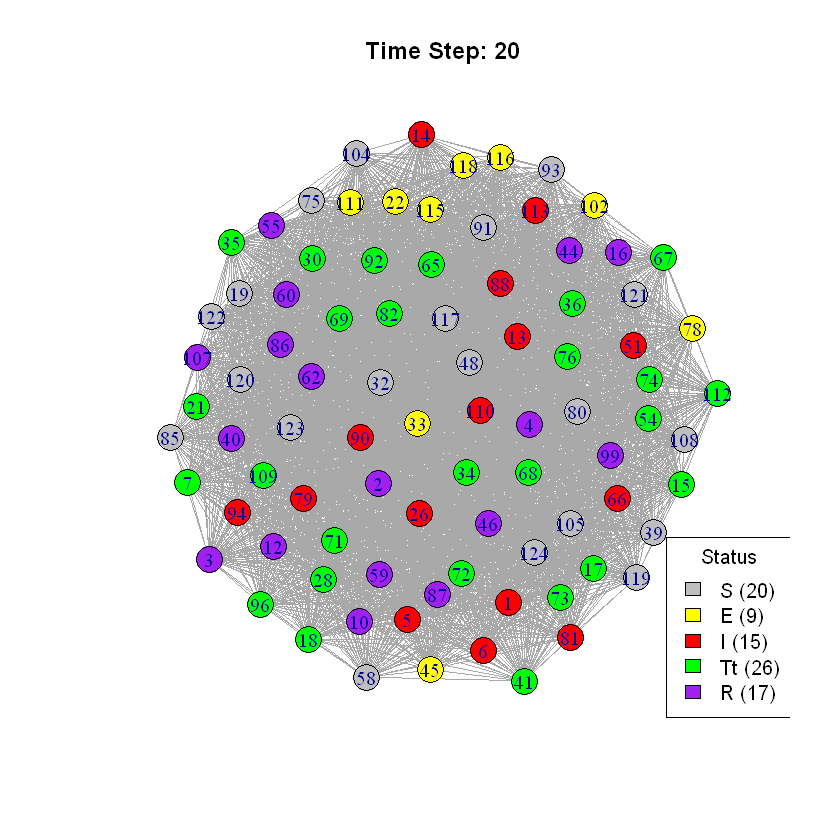

Time 31 : New node 136 added with status S 
Time 31 : New node 137 added with status S 
Time 31 : Node 26 changed status from I to Tt
Time 31 : Node 34 changed status from Tt to R
Time 31 : Node 81 changed status from I to R
Time 31 : Node 123 changed status from E to I
Time 31 : Node 130 changed status from E to I
Time 31 : Node 131 changed status from E to I
Time 32 : Node 116 with status E removed
Time 32 : New node 138 added with status S 
Time 32 : Node 28 changed status from Tt to R
Time 32 : Node 36 changed status from Tt to R
Time 32 : Node 39 changed status from E to I
Time 32 : Node 91 changed status from Tt to R
Time 33 : Node 130 with status I removed due to Infection
Time 33 : Node 69 with status Tt removed
Time 33 : New node 139 added with status S 
Time 33 : Node 119 changed status from E to I
Time 34 : Node 109 with status R removed
Time 34 : New node 140 added with status S 
Time 34 : Node 105 changed status from S to E
Time 34 : Node 125 changed status from E to I
Tim

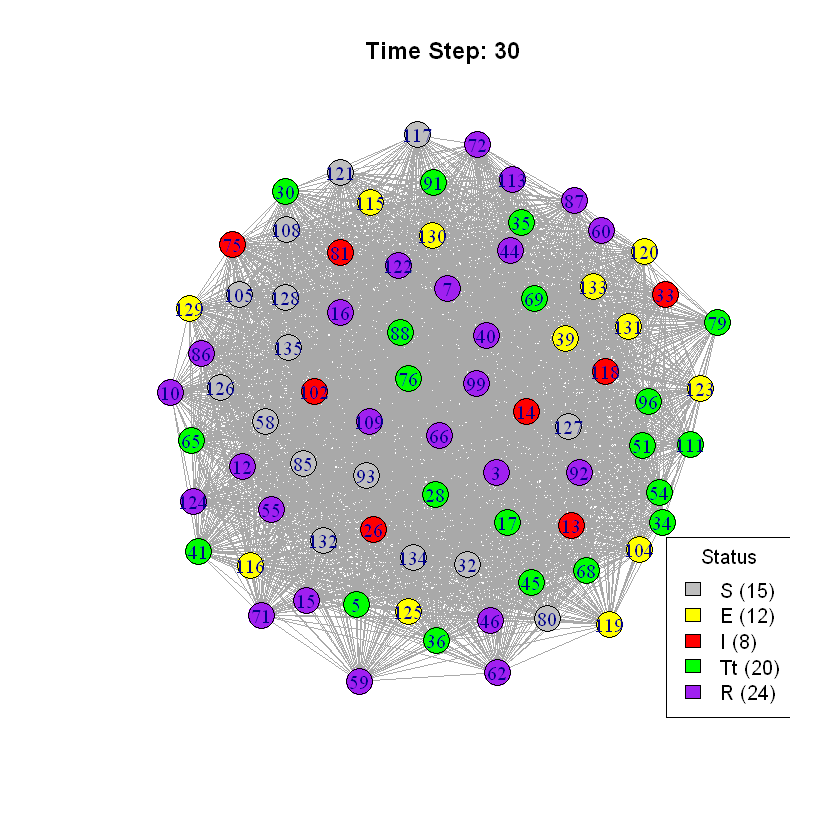

Time 41 : Node 41 with status Tt removed during Treatment
Time 41 : Node 16 with status R removed
Time 41 : New node 147 added with status S 
Time 41 : Node 80 changed status from E to I
Time 41 : Node 131 changed status from I to Tt
Time 41 : Node 143 changed status from S to E
Time 42 : New node 148 added with status S 
Time 42 : Node 85 changed status from E to I
Time 42 : Node 120 changed status from E to I
Time 42 : Node 127 changed status from S to E
Time 42 : Node 132 changed status from S to E
Time 42 : Node 141 changed status from S to E
Time 42 : Node 144 changed status from S to E
Time 42 : Node 147 changed status from S to E
Time 43 : Node 141 with status E removed
Time 43 : New node 149 added with status S 
Time 43 : Node 32 changed status from S to E
Time 43 : Node 33 changed status from I to Tt
Time 43 : Node 104 changed status from Tt to R
Time 43 : Node 108 changed status from I to Tt
Time 43 : Node 126 changed status from S to E
Time 43 : Node 134 changed status from 

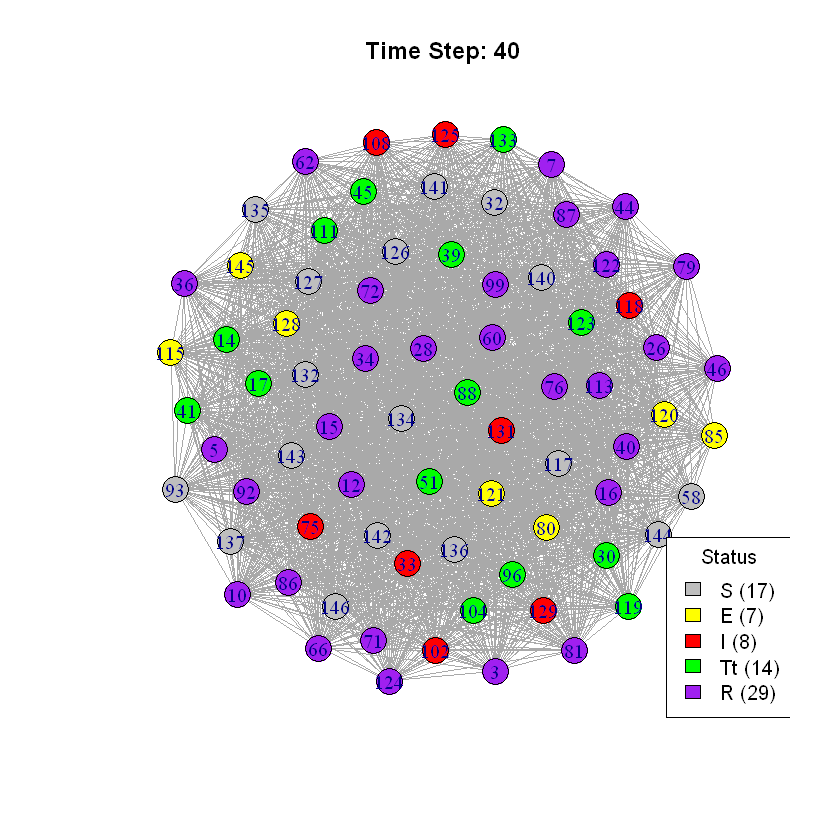

Time 51 : Node 96 with status Tt removed during Treatment
Time 51 : New node 157 added with status S 
Time 51 : Node 121 changed status from E to I
Time 51 : Node 143 changed status from E to I
Time 51 : Node 155 changed status from S to E
Time 52 : Node 145 with status Tt removed during Treatment
Time 52 : New node 158 added with status S 
Time 52 : Node 93 changed status from E to I
Time 52 : Node 121 changed status from I to Tt
Time 52 : Node 134 changed status from I to Tt
Time 52 : Node 142 changed status from E to I
Time 52 : Node 151 changed status from I to Tt
Time 52 : Node 155 changed status from E to I
Time 53 : Node 119 with status R removed
Time 53 : New node 159 added with status S 
Time 53 : Node 93 changed status from I to Tt
Time 53 : Node 147 changed status from E to I
Time 54 : Node 14 with status Tt removed during Treatment
Time 54 : New node 160 added with status S 
Time 54 : Node 111 changed status from Tt to R
Time 54 : Node 147 changed status from I to Tt
Time 5

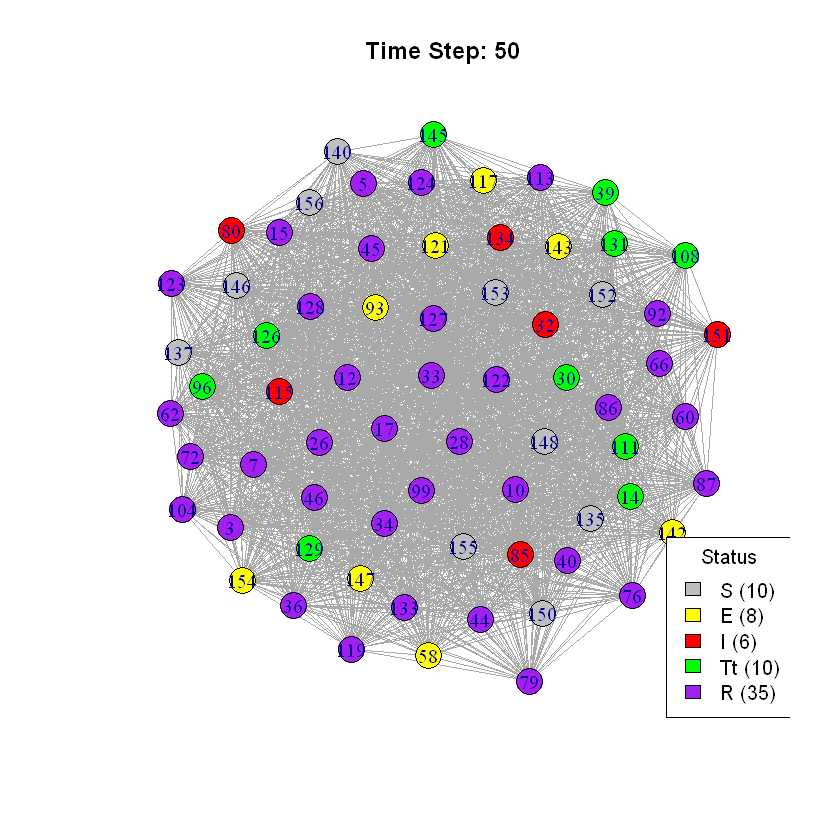

Time 61 : Node 39 with status Tt removed during Treatment
Time 61 : New node 168 added with status S 
Time 61 : Node 129 changed status from Tt to R
Time 61 : Node 165 changed status from S to E
Time 61 : Node 167 changed status from S to E
Time 62 : New node 169 added with status S 
Time 62 : New node 170 added with status S 
Time 62 : Node 80 changed status from Tt to R
Time 62 : Node 137 changed status from S to E
Time 62 : Node 146 changed status from S to E
Time 62 : Node 157 changed status from E to I
Time 62 : Node 163 changed status from E to I
Time 63 : Node 137 with status E removed
Time 63 : New node 171 added with status S 
Time 63 : Node 32 changed status from Tt to R
Time 63 : Node 115 changed status from I to Tt
Time 63 : Node 121 changed status from Tt to R
Time 63 : Node 156 changed status from S to E
Time 63 : Node 158 changed status from E to I
Time 63 : Node 167 changed status from E to I
Time 63 : Node 170 changed status from S to E
Time 64 : Node 86 with status R 

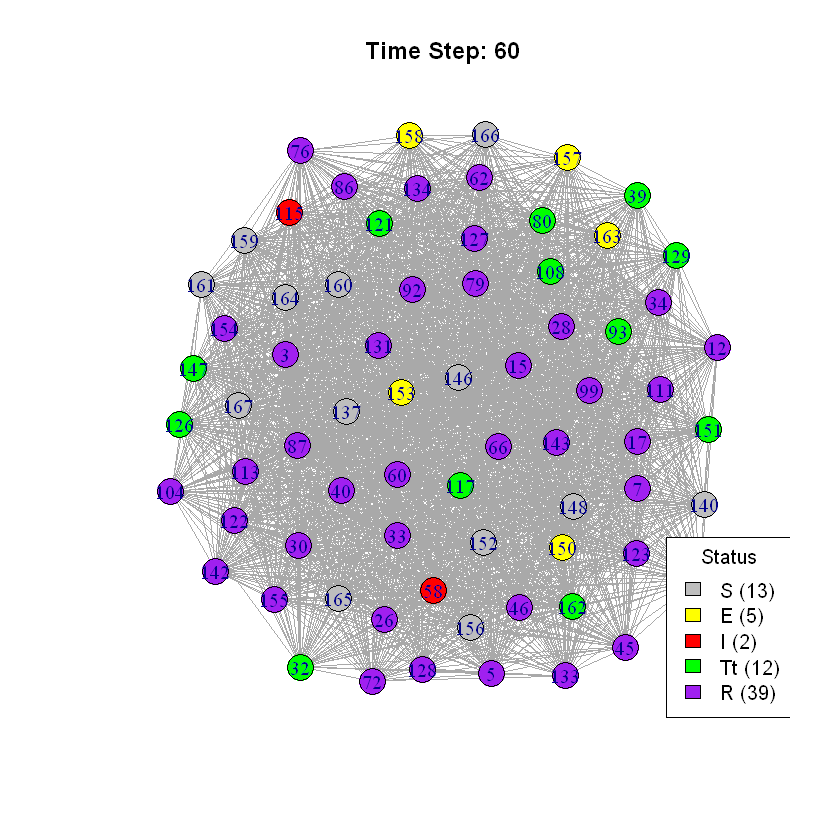

Time 71 : New node 179 added with status S 
Time 71 : Node 150 changed status from I to R
Time 71 : Node 174 changed status from E to I
Time 72 : Node 146 with status I removed
Time 72 : New node 180 added with status S 
Time 72 : New node 181 added with status S 
Time 72 : Node 152 changed status from E to I
Time 72 : Node 159 changed status from S to E
Time 72 : Node 165 changed status from E to I
Time 73 : Node 174 with status I removed due to Infection
Time 73 : New node 182 added with status S 
Time 73 : Node 140 changed status from S to E
Time 73 : Node 151 changed status from Tt to R
Time 73 : Node 157 changed status from I to Tt
Time 73 : Node 159 changed status from E to I
Time 74 : Node 177 with status S removed
Time 74 : New node 183 added with status S 
Time 74 : Node 140 changed status from E to I
Time 74 : Node 152 changed status from I to Tt
Time 74 : Node 175 changed status from S to E
Time 75 : Node 134 with status R removed
Time 75 : New node 184 added with status S 


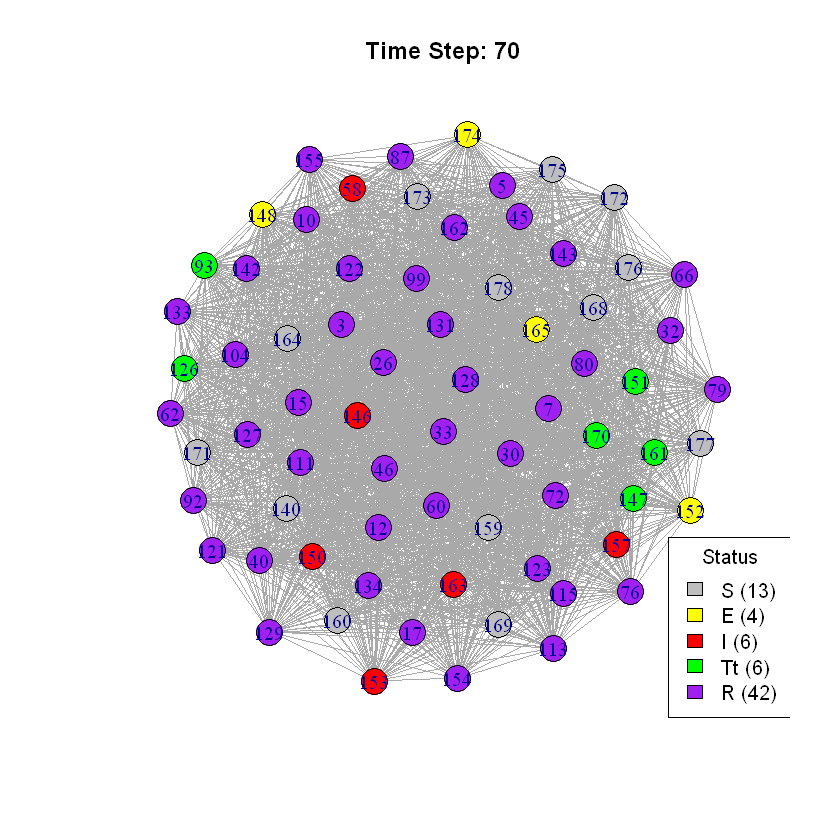

Time 81 : Node 168 with status S removed
Time 81 : New node 190 added with status S 
Time 81 : Node 178 changed status from I to Tt
Time 81 : Node 182 changed status from E to I
Time 81 : Node 190 changed status from S to E
Time 82 : Node 5 with status R removed
Time 82 : New node 191 added with status S 
Time 82 : Node 172 changed status from E to I
Time 82 : Node 175 changed status from I to Tt
Time 82 : Node 182 changed status from I to Tt
Time 83 : Node 165 with status I removed
Time 83 : New node 192 added with status S 
Time 83 : Node 172 changed status from I to Tt
Time 83 : Node 185 changed status from E to I
Time 83 : Node 187 changed status from S to E
Time 83 : Node 188 changed status from S to E
Time 84 : Node 175 with status Tt removed during Treatment
Time 84 : New node 193 added with status S 
Time 84 : New node 194 added with status S 
Time 84 : Node 93 changed status from Tt to R
Time 84 : Node 148 changed status from I to Tt
Time 84 : Node 164 changed status from S to

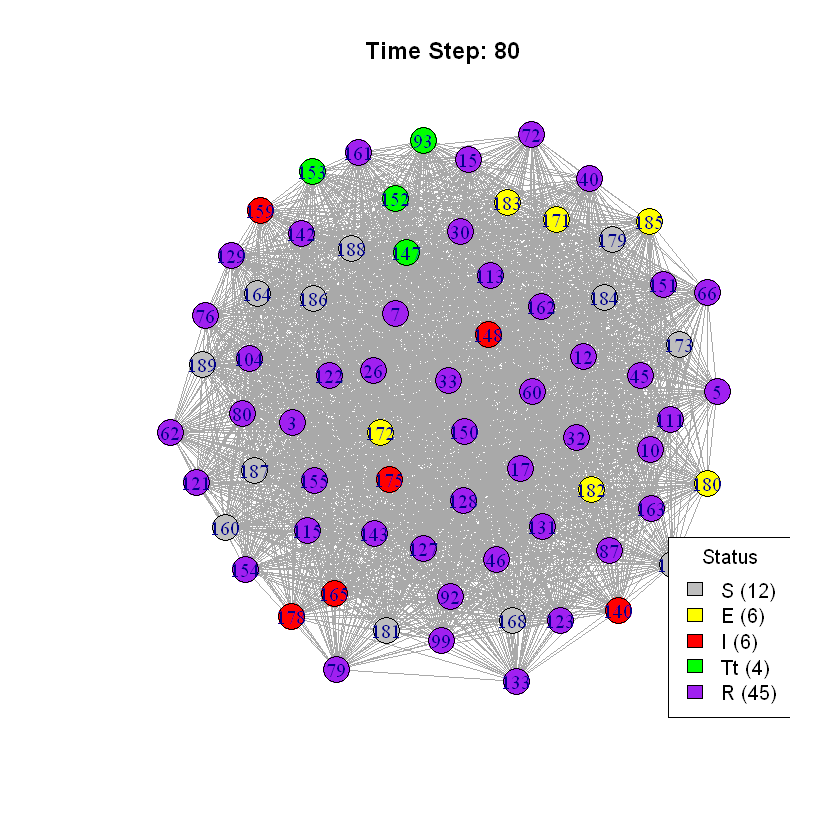

Time 91 : Node 153 with status Tt removed
Time 91 : New node 201 added with status S 
Time 91 : Node 164 changed status from E to I
Time 91 : Node 173 changed status from E to I
Time 91 : Node 186 changed status from E to I
Time 91 : Node 195 changed status from E to I
Time 92 : New node 202 added with status S 
Time 92 : Node 164 changed status from I to Tt
Time 92 : Node 173 changed status from I to Tt
Time 92 : Node 192 changed status from E to I
Time 93 : Node 180 with status I removed due to Infection
Time 93 : Node 187 with status Tt removed during Treatment
Time 93 : Node 80 with status R removed
Time 93 : New node 203 added with status S 
Time 93 : Node 160 changed status from E to I
Time 93 : Node 192 changed status from I to Tt
Time 93 : Node 195 changed status from I to Tt
Time 93 : Node 202 changed status from S to E
Time 94 : Node 121 with status R removed
Time 94 : New node 204 added with status S 
Time 94 : Node 160 changed status from I to Tt
Time 94 : Node 169 changed 

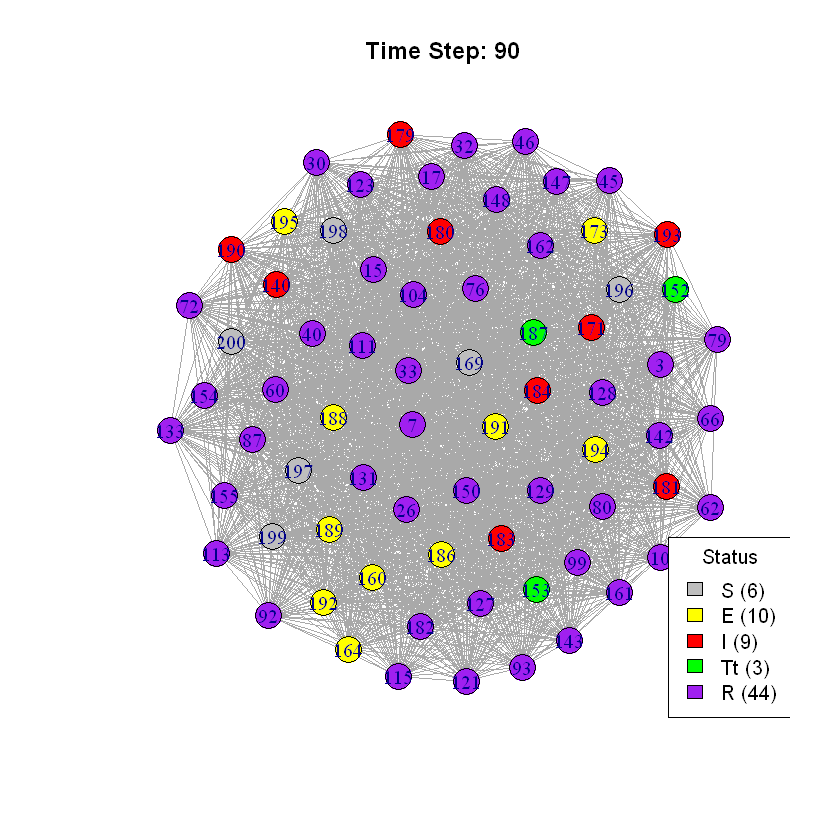

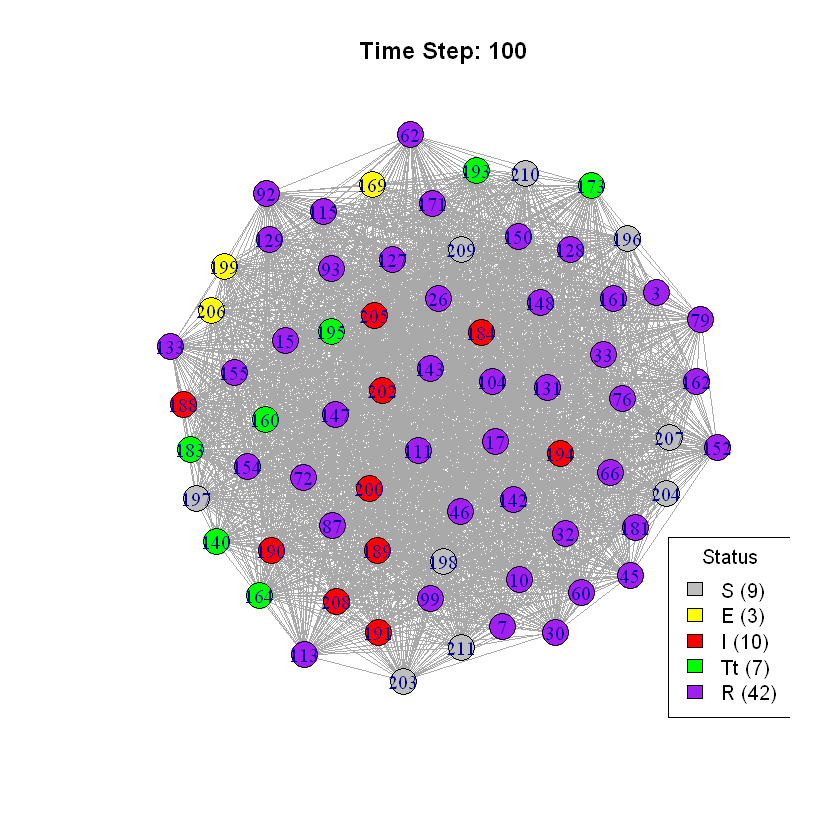

In [9]:
# Initialize a counter for the node labels
node_counter <- vcount(g)  # The current number of nodes in the graph


# Iterate over time steps
# This loop simulates the spread of the disease over time.
for (t in times) {
  # Save old statuses for tracking changes
  # This line saves the current status of each node so that we can track how the status changes over time.
  old_status <- V(g)$status
  
  # Calculate the number of nodes to remove due to Infection
  # This line calculates the number of nodes (individuals) that should be removed from the graph due to Infection.
  nodes_to_remove_count <- delta_I * sum(V(g)$status == "I")
  
  # Separate the integer and decimal parts
  # This line separates the integer and decimal parts of the number of nodes to remove.
  # The integer part represents the number of nodes that will definitely be removed, while the decimal part represents a probability that an additional node will be removed.
  floor_value <- floor(nodes_to_remove_count)
  fractional_part <- nodes_to_remove_count - floor_value
  
  # Get the nodes with status "I"
  # This line gets the IDs of the nodes that are currently Infected.
  nodes_with_status_I <- which(V(g)$status == "I")
  
  # If there are nodes to remove due to Infection
  if (floor_value > 0 && length(nodes_with_status_I) > 0){
    # Remove nodes based on the integer part
    # This loop removes a number of nodes equal to the integer part of the number of nodes to remove.
    for (i in 1:floor_value) {
      node_to_remove <- sample(nodes_with_status_I, 1)  # Select a node to remove at random
      cat("Time", t, ": Node", V(g)[node_to_remove]$label, "with status", V(g)[node_to_remove]$status, "removed due to Infection\n")  # Print a message indicating which node was removed
      g <- delete_vertices(g, node_to_remove)  # Remove the node from the graph
    }
  }
  
  # If there is a probability of removing an additional node due to Infection
  if (fractional_part > 0){
    # Use the decimal part as a probability to remove an additional node
    # This line removes an additional node with a probability equal to the decimal part of the number of nodes to remove.
    if (runif(1) < fractional_part) {
      node_to_remove <- sample(nodes_with_status_I, 1)  # Select a node to remove at random
      cat("Time", t, ": Node", V(g)[node_to_remove]$label, "with status", V(g)[node_to_remove]$status, "removed due to Infection\n")  # Print a message indicating which node was removed
      g <- delete_vertices(g, node_to_remove)  # Remove the node from the graph
    }
  }
  
  # Calculate the number of nodes to remove during Treatment
  # This line calculates the number of nodes (individuals) that should be removed from the graph during Treatment.
  nodes_to_remove_count <- delta_T * sum(V(g)$status == "Tt")
  
  # Separate the integer and decimal parts
  # This line separates the integer and decimal parts of the number of nodes to remove.
  # The integer part represents the number of nodes that will definitely be removed, while the decimal part represents a probability that an additional node will be removed.
  floor_value <- floor(nodes_to_remove_count)
  fractional_part <- nodes_to_remove_count - floor_value
  
  # Get the nodes with status "Tt"
  # This line gets the IDs of the nodes that are currently under Treatment.
  nodes_with_status_T <- which(V(g)$status == "Tt")
  
  # If there are nodes to remove during Treatment
  if (floor_value > 0){
    # Remove nodes based on the integer part
    # This loop removes a number of nodes equal to the integer part of the number of nodes to remove.
    for (i in 1:floor_value) {
      node_to_remove <- sample(nodes_with_status_T, 1)  # Select a node to remove at random
      cat("Time", t, ": Node", V(g)[node_to_remove]$label, "with status", V(g)[node_to_remove]$status, "removed during Treatment\n")  # Print a message indicating which node was removed
      g <- delete_vertices(g, node_to_remove)  # Remove the node from the graph
    }
  }
  
  # If there is a probability of removing an additional node during Treatment
  if (fractional_part > 0){
    # Use the decimal part as a probability to remove an additional node
    # This line removes an additional node with a probability equal to the decimal part of the number of nodes to remove.
    if (runif(1) < fractional_part) {
      node_to_remove <- sample(nodes_with_status_T, 1)  # Select a node to remove at random
      cat("Time", t, ": Node", V(g)[node_to_remove]$label, "with status", V(g)[node_to_remove]$status, "removed during Treatment\n")  # Print a message indicating which node was removed
      g <- delete_vertices(g, node_to_remove)  # Remove the node from the graph
    }
  }
  
  # Calculate the number of nodes to remove due to natural death
  # This line calculates the number of nodes (individuals) that should be removed from the graph due to natural death.
  nodes_to_remove_count <- mu * vcount(g)
  
  # Separate the integer and decimal parts
  # This line separates the integer and decimal parts of the number of nodes to remove.
  # The integer part represents the number of nodes that will definitely be removed, while the decimal part represents a probability that an additional node will be removed.
  floor_value <- floor(nodes_to_remove_count)
  fractional_part <- nodes_to_remove_count - floor_value
  
  # If there are nodes to remove due to natural death
  if (floor_value > 0){
    # Remove nodes based on the integer part
    # This loop removes a number of nodes equal to the integer part of the number of nodes to remove.
    for (i in 1:floor_value) {
      node_to_remove <- sample(vcount(g), 1)  # Select a node to remove at random
      cat("Time", t, ": Node", V(g)[node_to_remove]$label, "with status", V(g)[node_to_remove]$status, "removed\n")  # Print a message indicating which node was removed
      g <- delete_vertices(g, node_to_remove)  # Remove the node from the graph
    }
  }
  
  # If there is a probability of removing an additional node due to natural death
  if (fractional_part > 0){
    # Use the decimal part as a probability to remove an additional node
    # This line removes an additional node with a probability equal to the decimal part of the number of nodes to remove.
    if (runif(1) < fractional_part) {
      node_to_remove <- sample(vcount(g), 1)  # Select a node to remove at random
      cat("Time", t, ": Node", V(g)[node_to_remove]$label, "with status", V(g)[node_to_remove]$status, "removed\n")  # Print a message indicating which node was removed
      g <- delete_vertices(g, node_to_remove)  # Remove the node from the graph
    }
  }
  
  # Calculate the number of nodes to add
  # This line calculates the number of nodes (individuals) that should be added to the graph.
  nodes_to_add_count <- Lambda
  
  # Separate the integer and decimal parts
  # This line separates the integer and decimal parts of the number of nodes to add.
  # The integer part represents the number of nodes that will definitely be added, while the decimal part represents a probability that an additional node will be added.
  floor_value <- floor(nodes_to_add_count)
  fractional_part <- nodes_to_add_count - floor_value
  
  # If there are nodes to add
  if (floor_value > 0){
    # Add nodes based on the integer part
    # This loop adds a number of nodes equal to the integer part of the number of nodes to add.
    for (i in 1:floor_value) {
      node_counter <- node_counter + 1  # Increment the node counter
      new_status <- "S"  # The status of the new nodes is Susceptible (S)
      new_label <- node_counter  # The label of the new nodes is the current value of the node counter
      
      g <- add_vertices(g, 1)  # Add a new node to the graph
      V(g)[vcount(g)]$status <- new_status  # Assign the status to the new node
      V(g)[vcount(g)]$label <- new_label  # Assign the label to the new node
      
      # Choose nodes to attach to randomly
      # This line selects a number of nodes at random to which the new node will be connected.
      # The number of nodes to attach is the minimum of the initial probability times the current number of nodes and the current number of nodes minus one.
      nodes_to_attach <- sample(V(g), size = min(round(init_p * vcount(g)), vcount(g) - 1))
      
      # Add edges to these nodes
      # This loop adds an edge from the new node to each of the selected nodes.
      for (node_to_attach in nodes_to_attach) {
        if (V(g)[node_to_attach]$label != new_label) { # No self edges
          g <- add_edges(g, c(vcount(g), node_to_attach))  # Add an edge from the new node to the selected node
        }
      }
      
      # Print new node
      # This line prints a message indicating that a new node was added and its status.
      cat("Time", t, ": New node", new_label, "added with status", new_status, "\n")
    }
  }
  
  # If there is a probability of adding an additional node
  if (fractional_part > 0){
    # Use the decimal part as a probability to add an additional node
    # This line adds an additional node with a probability equal to the decimal part of the number of nodes to add.
    if (runif(1) < fractional_part) {
      node_counter <- node_counter + 1  # Increment the node counter
      new_status <- "S"  # The status of the new node is Susceptible (S)
      new_label <- node_counter  # The label of the new node is the current value of the node counter
      
      g <- add_vertices(g, 1)  # Add a new node to the graph
      V(g)[vcount(g)]$status <- new_status  # Assign the status to the new node
      V(g)[vcount(g)]$label <- new_label  # Assign the label to the new node
      
      # Choose nodes to attach to randomly
      nodes_to_attach <- sample(V(g), size = min(round(init_p * vcount(g)), vcount(g) - 1))
      
      # Add edges to these nodes
      for (node_to_attach in nodes_to_attach) {
        if (V(g)[node_to_attach]$label != new_label) { # No self edges
          g <- add_edges(g, c(vcount(g), node_to_attach))  # Add an edge from the new node to the selected node
        }
      }
      
      # Print new node
      cat("Time", t, ": New node", new_label, "added with status", new_status, "\n")
    }
  }
  
  # Iterate over nodes for status changes
  # This loop iterates over each node in the graph to update its status based on the model parameters and its current status.
  for (i in V(g)) {
    # Get current status
    status <- V(g)[i]$status
    
    # Generate a random number
    rand <- runif(1)
    
    # Update status based on model parameters and current status
    if (status == "S") {
      # If the node is Susceptible (S) and the random number is less than beta1 * I / N, change the status to Exposed (E).
      if (rand < beta1 * I / N) {
        V(g)[i]$status <- "E"
        cat("Time", t, ": Node", V(g)[i]$label, "changed status from S to E\n")
      }
    } else if (status == "E" && rand < beta2) {
      # If the node is Exposed (E) and the random number is less than beta2, change the status to Infected (I).
      V(g)[i]$status <- "I"
      cat("Time", t, ": Node", V(g)[i]$label, "changed status from E to I\n")
    } else if (status == "I") {
      # If the node is Infected (I), generate another random number.
      rand2 <- runif(1)
      if (rand < beta3) {
        # If the first random number is less than beta3, change the status to Recovered (R).
        V(g)[i]$status <- "R"
        cat("Time", t, ": Node", V(g)[i]$label, "changed status from I to R\n")
      } else if (rand2 < alpha1) {
        # If the second random number is less than alpha1, change the status to Treatment (Tt).
        V(g)[i]$status <- "Tt"
        cat("Time", t, ": Node", V(g)[i]$label, "changed status from I to Tt\n")
      }
    } else if (status == "Tt" && rand < alpha2) {
      # If the node is under Treatment (Tt) and the random number is less than alpha2, change the status to Recovered (R).
      V(g)[i]$status <- "R"
      cat("Time", t, ": Node", V(g)[i]$label, "changed status from Tt to R\n")
    }
  }
  
  # Store counts
  # This section of the code counts the number of nodes in each status at the current time step and stores these counts in the corresponding vectors.
  S_count[t+1] <- sum(V(g)$status == "S")
  E_count[t+1] <- sum(V(g)$status == "E")
  I_count[t+1] <- sum(V(g)$status == "I")
  Tt_count[t+1] <- sum(V(g)$status == "Tt")
  R_count[t+1] <- sum(V(g)$status == "R")
  N_count[t+1] <- vcount(g)
  
  # Calculate and store metrics
  # This section of the code calculates various network metrics at the current time step and stores these metrics in the corresponding vectors.
  degree_dist[[t+1]] <- degree_distribution(g)  # Degree distribution
  clustering_coeff[t+1] <- transitivity(g, type = "global")  # Clustering coefficient
  avg_path_length[t+1] <- mean_distance(g, directed = FALSE)  # Average path length
  comps <- components(g)  # Connected components
  largest_comp_size[t+1] <- max(comps$csize)  # Size of the largest connected component
  
  # Plot network in every 10th time step
  # This loop plots the network at every 10th time step.
  # Each node is colored according to its status, and the plot includes a legend showing the number of nodes in each status.
  if (t %% 10 == 0) {
    plot(g, vertex.color = status_colors[V(g)$status], vertex.size=10, vertex.label=V(g)$label)
    title(paste("Time Step:", t))
    status_counts <- table(V(g)$status)
    status_labels <- paste(names(status_colors), " (", status_counts[names(status_colors)], ")", sep = "")
    legend("bottomright", legend = status_labels, fill = status_colors, title = "Status")
  }
}

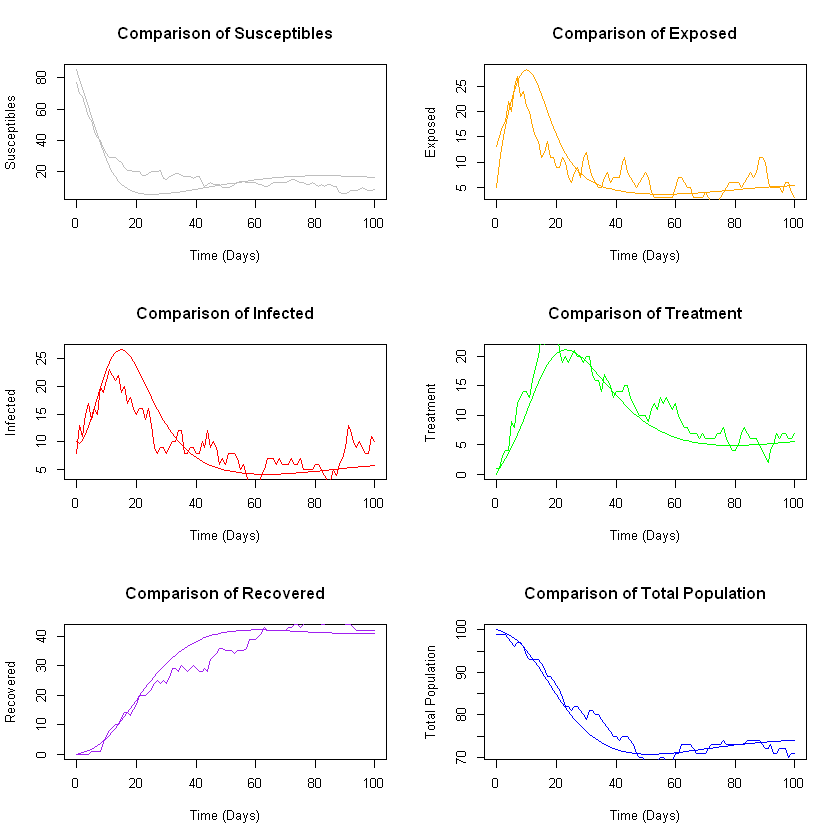

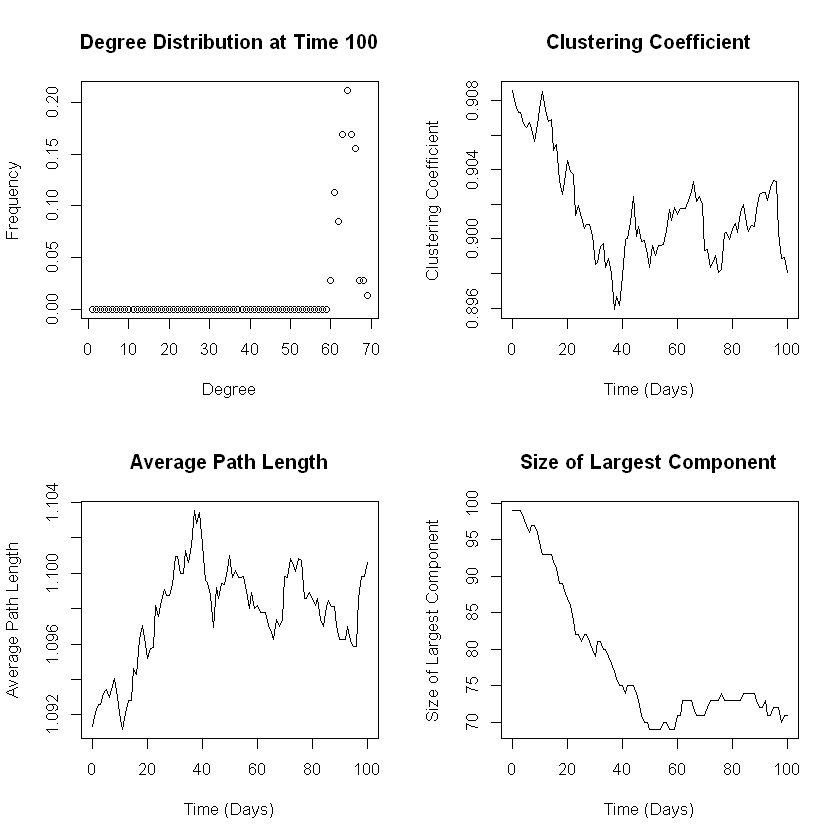

In [10]:
# Set up a single plot for comparison
# This section of the code sets up a 3x2 grid of plots for comparing the number of individuals in each status (S, E, I, Tt, R, N) over time.
par(mfrow = c(3, 2))
plot(out[, "time"], out[, "S"], type = "l", col = status_colors["S"], xlab = "Time (Days)", ylab = "Susceptibles", main = "Comparison of Susceptibles")
lines(times, S_count, col = status_colors["S"])
plot(out[, "time"], out[, "E"], type = "l", col = "orange", xlab = "Time (Days)", ylab = "Exposed", main = "Comparison of Exposed")
lines(times, E_count, col = "orange")
plot(out[, "time"], out[, "I"], type = "l", col = status_colors["I"], xlab = "Time (Days)", ylab = "Infected", main = "Comparison of Infected")
lines(times, I_count, col = status_colors["I"])
plot(out[, "time"], out[, "Tt"], type = "l", col = status_colors["Tt"], xlab = "Time (Days)", ylab = "Treatment", main = "Comparison of Treatment")
lines(times, Tt_count, col = status_colors["Tt"])
plot(out[, "time"], out[, "R"], type = "l", col = status_colors["R"], xlab = "Time (Days)", ylab = "Recovered", main = "Comparison of Recovered")
lines(times, R_count, col = status_colors["R"])
plot(out[, "time"], out[, "N"], type = "l", col = "blue", xlab = "Time (Days)", ylab = "Total Population", main = "Comparison of Total Population")
lines(times, N_count, col = "blue")

# Plot metrics
# This section of the code plots various network metrics over time.
# These metrics include the degree distribution, clustering coefficient, average path length, and size of the largest connected component.
par(mfrow = c(2, 2))
plot(degree_dist[[t+1]], main = paste("Degree Distribution at Time", t), xlab = "Degree", ylab = "Frequency")
plot(times, clustering_coeff, type = "l", xlab = "Time (Days)", ylab = "Clustering Coefficient", main = "Clustering Coefficient")
plot(times, avg_path_length, type = "l", xlab = "Time (Days)", ylab = "Average Path Length", main = "Average Path Length")
plot(times, largest_comp_size, type = "l", xlab = "Time (Days)", ylab = "Size of Largest Component", main = "Size of Largest Component")

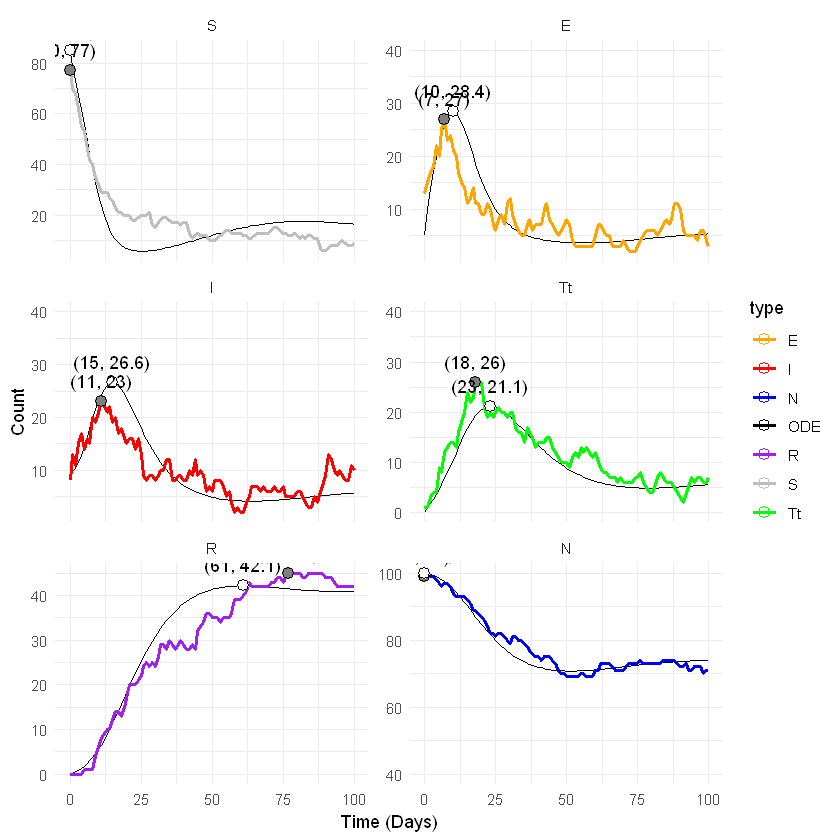

In [16]:
# Create a data frame from your data
df_ode <- data.frame(time = out[, "time"], 
                     S = out[, "S"], 
                     E = out[, "E"], 
                     I = out[, "I"], 
                     Tt = out[, "Tt"], 
                     R = out[, "R"], 
                     N = out[, "N"],
                     type = "ODE")

df_net <- data.frame(time = times, 
                     S = S_count, 
                     E = E_count, 
                     I = I_count, 
                     Tt = Tt_count, 
                     R = R_count, 
                     N = N_count,
                     type = "Network")

df <- rbind(df_ode, df_net)

# Reshape the data to long format for ggplot
df_long <- tidyr::pivot_longer(df, -c(time, type), names_to = "status", values_to = "count")

# Get peak points for each status and type
peaks <- df_long %>%
  group_by(status, type) %>%
  slice(which.max(count)) %>%
  ungroup() %>%
  mutate(label = paste0("(", round(time, 1), ", ", round(count, 1), ")"))

# Define colors for network solution
network_colors <- c("S" = "gray", "E" = "orange", "I" = "red", "Tt" = "green", "R" = "purple", "N" = "blue")

# Plot
ggplot(df_long, aes(x = time, y = count)) +
  geom_line(data = df_long[df_long$type == "ODE", ], aes(color = type)) +
  geom_line(data = df_long[df_long$type == "Network", ], aes(color = status), linewidth= 1.1) +
  geom_point(data = peaks, aes(fill = type, color = NULL), size = 3, shape = 21) +
  geom_text(data = peaks, aes(label = label), vjust = -1) +
  scale_color_manual(values = c("ODE" = "black", network_colors)) +
  scale_fill_manual(values = c("ODE" = "white", "Network" = network_colors), guide = FALSE) +
  labs(x = "Time (Days)", y = "Count") +
  facet_wrap(~ factor(status, levels = c("S", "E", "I", "Tt", "R", "N")), scales = "free_y", ncol = 2) +
  theme_minimal() +
  expand_limits(y = max(df_long$count) * .4) # Expand y-axis limits